In [409]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from skimage.metrics import structural_similarity as ss

# Approximating Images with circles using Differential Evolution Algorithms

#### Helper functions

In [251]:
def load_image(image_path, size=None):
    target = cv2.imread(image_path, cv2.IMREAD_COLOR)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

    if size:
        target = cv2.resize(src=target, dsize=size, interpolation=cv2.INTER_AREA)
    return target

In [252]:
def show_image(img_arr):
    plt.figure()
    plt.axis("off")
    plt.imshow(img_arr / 255)
    plt.show()

In [374]:
class Fitness:
    def __init__(self, target):
        self.target = target
        self.max_error = (np.square((1 - (self.target >= 127)) * 255 - self.target)).mean(axis=None)

    def score(self, individual):
        individual = cv2.resize(src=individual, dsize=self.target.shape[:-1], interpolation=cv2.INTER_AREA)
        fit = (np.square(individual - self.target)).mean(axis=None)
        fit = (self.max_error - fit) / self.max_error
        return fit

    def show_fitness(self, individual):
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.title("Target Image")
        plt.imshow(self.target / 255)
        plt.subplot(1,2,2)
        plt.title("Circle Approximation")
        plt.imshow(individual / 255)
        plt.show()


(64, 64, 3)
<class 'numpy.ndarray'>


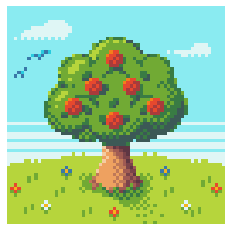

In [375]:
target = load_image("./arbol.png", size=(64, 64))
print(target.shape)
print(type(target))
show_image(target)

In [255]:
bounds = [
    [0,1],                     # X position
    [0,1],                     # Y position
    [0,1],                      # Radius
    [0,1],                      # Red
    [0,1],                      # Green
    [0,1],                      # Blue
    [0,1]                       # Alpha
]

In [262]:
def generate_circles(bounds, size):
    var_no = len(bounds)
    
    circles = np.random.uniform(0,1, size=(size, var_no))

    return np.array(circles)
        

<class 'matplotlib.figure.Figure'> <class 'matplotlib.axes._subplots.AxesSubplot'>


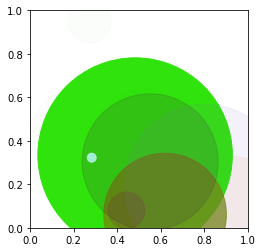

In [263]:
# plt.Circle((X,Y), radius, color, alpha)

#circle1 = plt.Circle((c[0], c[1]), radius=c[2], color=(c[3], c[4], c[5]), alpha=c[6])

fig, ax = plt.subplots()
print(type(fig), type(ax))
ax.set_aspect( 1 )

for c in circles:
    circle1 = plt.Circle((c[0], c[1]), radius=c[2], color=(c[3], c[4], c[5]), alpha=c[6])
    ax.add_patch(circle1)
#fig.add_subplot(ax)
plt.show(fig)

In [385]:
# X Y r R G B a
# 0 1 2 3 4 5 6

def get_image(genotype):
    size = target.shape
    
    gtype_img = np.zeros(size)
    gtype_img.fill(255)
    radius_avg = (size[0] + size[1]) / 2 / 6
        
    for row in genotype:
        overlay = gtype_img.copy()
        color = (row[3:-1] * 255).astype(np.uint8).tolist()
        
        cv2.circle(
            overlay,
            center = (int(row[1] * size[1]), int(row[0] * size[0])),
            radius = int(row[2] * radius_avg),
            color = color,
            thickness = -1
        )
            
        alpha = row[-1]
        gtype_img = cv2.addWeighted(overlay, alpha, gtype_img, 1 - alpha, 0)
    
    return gtype_img

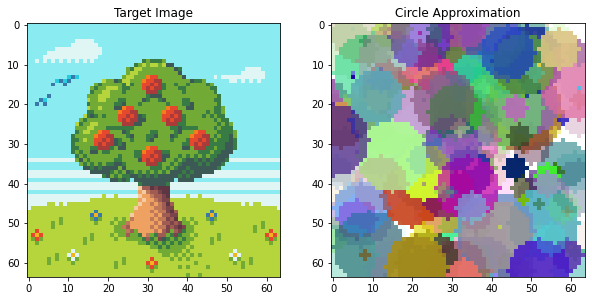

Score: 0.8093785744067754


In [391]:
fitness = Fitness(target)
genotype = generate_circles(bounds, 200)
circles_image = get_image(genotype)

fitness.show_fitness(circles_image)

print("Score:", fitness.score(circles_image))
#print("Genotype:", (genotype[:, 3:-1]*255).astype('uint8'))


In [404]:
class Individual:
    def __init__(self, size, genes=128, genotype=None):
        self.size = size
        self.genotype_width = 5 if len(size) < 3 else 7
        self.genotype = genotype if genotype is not None else np.random.rand(genes, self.genotype_width)
        self.phenotype = np.zeros(size)

    def genes(self):
        return self.genotype.shape[0]

    def genotype_to_image(self):
        self.phenotype.fill(255)
        radius_avg = (self.size[0] + self.size[1]) / 2 / 6
        
        for row in self.genotype:
            overlay = self.phenotype.copy()
            color = (row[3:-1] * 255).astype(np.uint8).tolist()
            cv2.circle(
                overlay,
                center = (int(row[1] * self.size[1]), int(row[0] * self.size[0])),
                radius = int(row[2] * radius_avg),
                color = color,
                thickness = -1,
            )

            alpha = row[-1]
            self.phenotype = cv2.addWeighted(overlay, alpha, self.phenotype, 1 - alpha, 0)



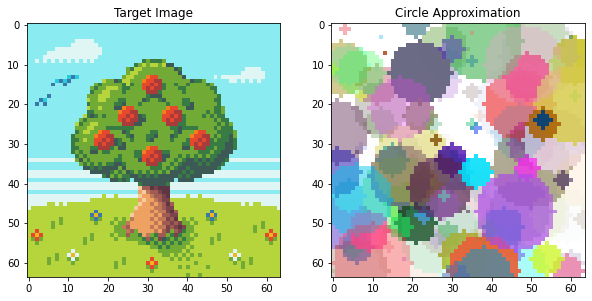

Score: 0.7906519282549589


In [408]:
fitness = Fitness(target)
ind = Individual(size=target.shape)

ind.genotype_to_image()
fitness.show_fitness(ind.phenotype)

print("Score:", fitness.score(ind.phenotype))

In [418]:
class Evolution:
    def __init__(self, target, genes=100):
        self.size = target.shape        # np.shape of target image
        self.target = target            # Target image for evolutio
        self.generations = 1            # No. of generations
        self.genes = genes              # No. of circle to train the target image on
        self.specie = Individual(size=self.size, genes=genes)

    def mutate(self, specie):
        new_specie = Individual(size=self.size, genotype=np.array(specie.genotype))

        # Randomization for Evolution
        y = random.randint(0, self.genes - 1)
        change = random.randint(0, 6)

        if change >= 6:
            change -= 1
            i, j = y, random.randint(0, self.genes - 1)
            i, j, s = (i, j, -1) if i < j else (j, i, 1)
            new_specie.genotype[i : j + 1] = np.roll(new_specie.genotype[i : j + 1], shift=s, axis=0)
            y = j

        selection = np.random.choice(5, size=change, replace=False)

        if random.random() < 0.25:
            new_specie.genotype[y, selection] = np.random.rand(len(selection))
        else:
            new_specie.genotype[y, selection] += (np.random.rand(len(selection)) - 0.5) / 3
            new_specie.genotype[y, selection] = np.clip(new_specie.genotype[y, selection], 0, 1)

        return new_specie

    def print_progress(self, fit):
        print("GEN {}, FIT {:.8f}".format(self.generation, fit))

    def evolve(self, fitness=Fitness, max_generation=100000):
        fitness = fitness(self.target)

        self.specie.genotype_to_image()
        fit = fitness.score(self.specie.phenotype)

        for i in range(max_generation):
            self.generation = i + 1

            mutated = self.mutate(self.specie)
            mutated.genotype_to_image()
            newfit = fitness.score(mutated.phenotype)

            if newfit > fit:
                fit = newfit
                self.specie = mutated
                self.print_progress(newfit)

    

GEN 1, FIT 0.76633902
GEN 3, FIT 0.76633927
GEN 4, FIT 0.76636416
GEN 5, FIT 0.76641461
GEN 6, FIT 0.76688474
GEN 7, FIT 0.76726066
GEN 8, FIT 0.76741659
GEN 9, FIT 0.76793778
GEN 14, FIT 0.76928740
GEN 15, FIT 0.76928847
GEN 16, FIT 0.77939675
GEN 18, FIT 0.77945028
GEN 19, FIT 0.77980199
GEN 23, FIT 0.78132490
GEN 26, FIT 0.78218759
GEN 27, FIT 0.78235519
GEN 34, FIT 0.78242214
GEN 36, FIT 0.78974534
GEN 37, FIT 0.78996079
GEN 38, FIT 0.78998040
GEN 39, FIT 0.79001401
GEN 44, FIT 0.79023105
GEN 47, FIT 0.79025927
GEN 49, FIT 0.79030944
GEN 60, FIT 0.79049309
GEN 63, FIT 0.79240041
GEN 64, FIT 0.79244978
GEN 66, FIT 0.79707738
GEN 67, FIT 0.79707893
GEN 81, FIT 0.79748852
GEN 85, FIT 0.79749318
GEN 90, FIT 0.79751164
GEN 92, FIT 0.79751282
GEN 97, FIT 0.79751296
GEN 99, FIT 0.79753541
GEN 100, FIT 0.79755038
GEN 104, FIT 0.79755044
GEN 105, FIT 0.79811296
GEN 107, FIT 0.79815092
GEN 109, FIT 0.79843536
GEN 113, FIT 0.79844256
GEN 121, FIT 0.79861686
GEN 123, FIT 0.79873676
GEN 125, FI

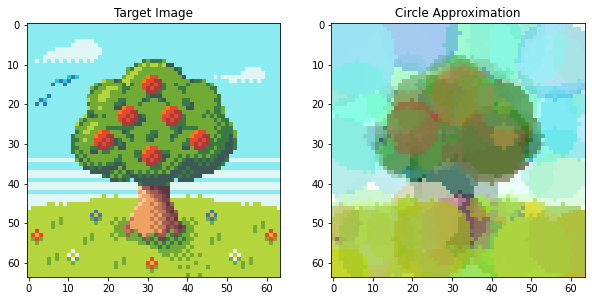

In [430]:
size = (64,64)
genes = 100
max_gen = 10000

evolution = Evolution(target, genes=120)
evolution.evolve(max_generation=max_gen)

evolution.specie.genotype_to_image()
fitness.show_fitness(evolution.specie.phenotype)


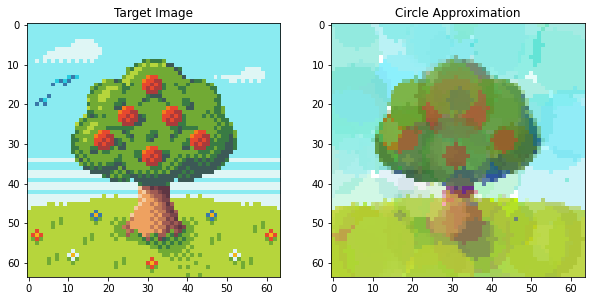

In [426]:
iter_100k_result = evolution.specie.phenotype
fitness.show_fitness(iter_100k_result)

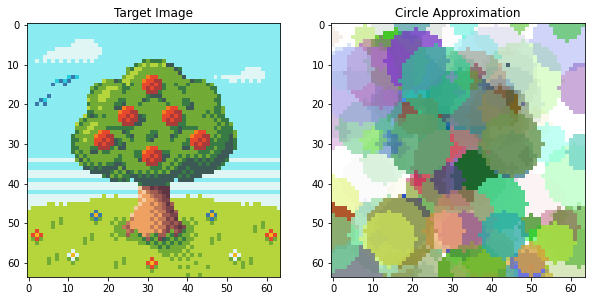

In [429]:
iter_1k_result = evolution.specie.phenotype
fitness.show_fitness(iter_1k_result)

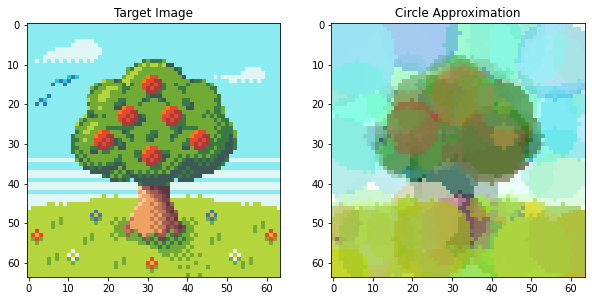

In [431]:
iter_10k_result = evolution.specie.phenotype
fitness.show_fitness(iter_10k_result)

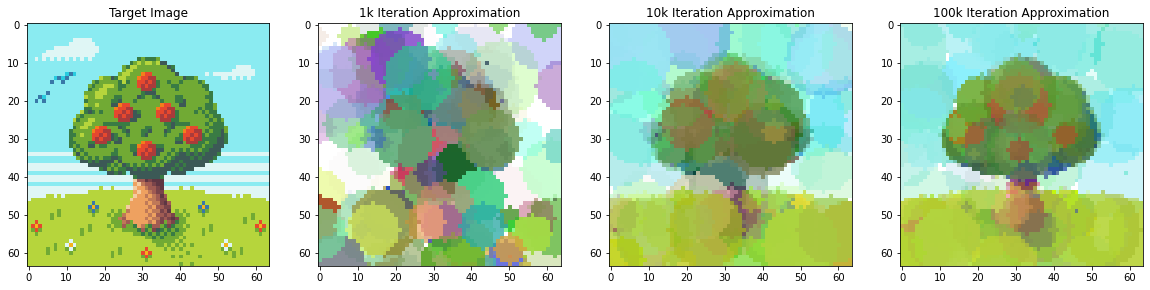

In [436]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title("Target Image")
plt.imshow(target / 255)
plt.subplot(1,4,2)
plt.title("1k Iteration Approximation")
plt.imshow(iter_1k_result / 255)
plt.subplot(1,4,3)
plt.title("10k Iteration Approximation")
plt.imshow(iter_10k_result / 255)
plt.subplot(1,4,4)
plt.title("100k Iteration Approximation")
plt.imshow(iter_100k_result / 255)
plt.savefig('iter_difference.png',facecolor='white')
